In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Imports
import pathlib as pl
import PIL
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import seaborn as sns
import math
import pandas as pd
from typing import List, Optional, Tuple, Dict

import time
import tensorflow as tf
from tensorflow import keras 
import keras_tuner
from keras import Sequential, Input, layers, optimizers, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2025-08-26 05:11:48.128158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756185108.279946      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756185108.325711      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Running on CPU.")

2 Physical GPUs, 2 Logical GPUs


I0000 00:00:1756185120.262579      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756185120.263306      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## 1. Exploratory Data Analysis (EDA)

Inspect, Visualize and Clean the Data

### Initial Data Assessment

In [4]:
data = pl.Path('/kaggle/input/histopathologic-cancer-detection')
test = data/'test'
train = data/'train'
train_labels = data/'train_labels.csv'

In [5]:
labels_df = pd.read_csv(train_labels)
test_list = list(test.glob('*.tif'))
test_df = pd.DataFrame({'paths': test_list})
assert len(labels_df) == 220025
assert len(test_df) == 57458

In [6]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
# Basic statistics of the labels dataframe
labels_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


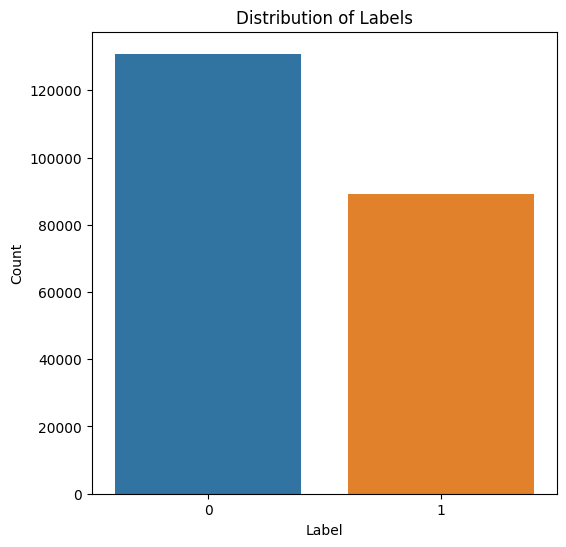

In [8]:
# Histogram of labels
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
def gen_train_paths(row):
    file = row.id + '.tif'
    path = train/file
    #check that all of the training images exist (slow)
    #assert path.exists()
    return path
labels_df['paths'] = labels_df.progress_apply(gen_train_paths, axis = 1)

100%|██████████| 220025/220025 [00:03<00:00, 71220.13it/s]


In [10]:
def visualize_histopathology_samples(
    data_df: pd.DataFrame,
    n: int,
    figsize_per_image: Tuple[float, float] = (3, 3.5),
    max_cols: int = 5,
    title: str = "Histopathologic Image Samples",
    save_path: Optional[Path] = None,
    dpi: int = 100,
    random_state: Optional[int] = None
) -> plt.Figure:    
    # Validate required columns
    required_columns = {'id', 'label', 'paths'}
    if not required_columns.issubset(data_df.columns):
        missing = required_columns - set(data_df.columns)
        raise ValueError(f"Missing required columns: {missing}")
    
    # Sample n rows from the dataframe
    if len(data_df) <= n:
        sample_df = data_df.copy()
    else:
        sample_df = data_df.sample(n=n, random_state=random_state)
    
    # Convert paths column to Path objects if needed
    sample_df['paths'] = sample_df['paths'].apply(lambda x: Path(x) if not isinstance(x, Path) else x)
    
    # Calculate grid dimensions
    n_images = len(sample_df)
    n_cols = min(n_images, max_cols)
    n_rows = math.ceil(n_images / n_cols)
    
    # Create figure with calculated size
    fig_width = n_cols * figsize_per_image[0]
    fig_height = n_rows * figsize_per_image[1]
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    # Create grid specification for better spacing control
    gs = fig.add_gridspec(n_rows, n_cols, hspace=0.3, wspace=0.2, 
                         top=0.94, bottom=0.02, left=0.02, right=0.98)
    
    # Process and display each image
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        grid_row = idx // n_cols
        grid_col = idx % n_cols
        ax = fig.add_subplot(gs[grid_row, grid_col])
        
        try:
            # Load and display image
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Verify expected image format
            if img_array.shape != (96, 96, 3):
                print(f"Warning: Image {row['id']} has unexpected shape {img_array.shape}")
            
            ax.imshow(img_array)
            
            # Get label information from DataFrame row
            image_id = row['id']
            label = row['label']
            
            # Format label text with appropriate color
            if label == 1:
                label_text = "Positive (Cancer)"
                label_color = 'darkred'
            elif label == 0:
                label_text = "Negative (Normal)"
                label_color = 'darkgreen'
            else:
                label_text = "Unknown Label"
                label_color = 'gray'
            
            # Set title with class label
            ax.set_title(f"{label_text}\n{image_id}", 
                        fontsize=10, pad=5, color=label_color)
            
            # Remove axis ticks for cleaner appearance
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add subtle border
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)
                
        except Exception as e:
            # Handle loading errors gracefully
            ax.text(0.5, 0.5, f"Error loading\n{row['id']}\n{str(e)}", 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=9, color='red', wrap=True)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Remove any empty subplots
    for idx in range(n_images, n_rows * n_cols):
        grid_row = idx // n_cols
        grid_col = idx % n_cols
        ax = fig.add_subplot(gs[grid_row, grid_col])
        ax.set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    # Close the figure to prevent duplicate display
    plt.close(fig)
    
    return fig

/tmp/ipykernel_19/1289536043.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


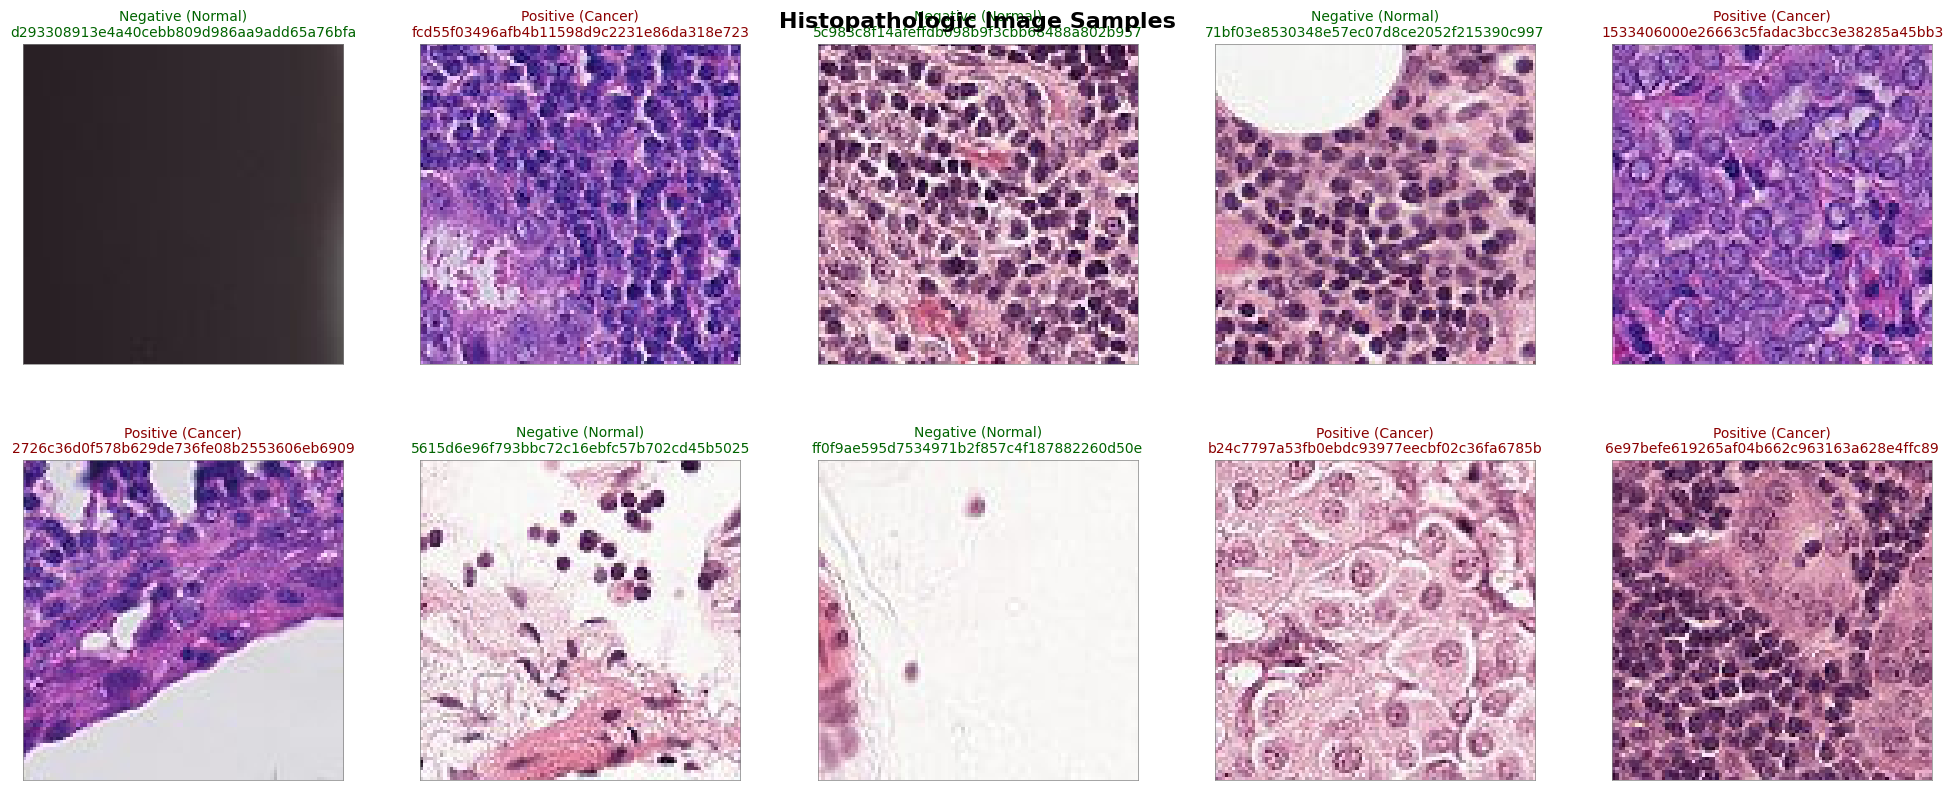

In [11]:
visualize_histopathology_samples(
    data_df = labels_df,
    n = 10,
    figsize_per_image = (4,4),
    max_cols = 5,
    title = "Histopathologic Image Samples",
    save_path = None,
    dpi = 100,
    random_state = 42
)

In [12]:
def analyze_pixel_distributions(data_df, n_samples=5000, random_state=42):
    """
    Analyze pixel intensity distributions across classes and color channels.
    
    Parameters:
    - data_df: DataFrame with 'paths' and 'label' columns
    - n_samples: Number of images to analyze (default 5000 for efficiency)
    - random_state: Random seed for reproducible sampling
    
    Returns:
    - Dictionary containing computed statistics and data for visualization
    """
    import numpy as np
    from PIL import Image
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    # Sample data for efficiency
    sample_df = data_df.sample(n=min(n_samples, len(data_df)), random_state=random_state)
    
    # Initialize storage for pixel values by class and channel
    pixel_data = {
        0: {'R': [], 'G': [], 'B': [], 'gray': []},
        1: {'R': [], 'G': [], 'B': [], 'gray': []}
    }
    
    # Collect pixel intensities
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), 
                      desc="Analyzing pixel intensities"):
        try:
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Extract each channel
            pixel_data[row['label']]['R'].extend(img_array[:,:,0].flatten())
            pixel_data[row['label']]['G'].extend(img_array[:,:,1].flatten())
            pixel_data[row['label']]['B'].extend(img_array[:,:,2].flatten())
            
            # Calculate grayscale for overall intensity
            gray = np.mean(img_array, axis=2)
            pixel_data[row['label']]['gray'].extend(gray.flatten())
            
        except Exception as e:
            print(f"Error processing {row['id']}: {e}")
    
    # Compute statistics
    statistics = {}
    for label in [0, 1]:
        statistics[label] = {}
        for channel in ['R', 'G', 'B', 'gray']:
            channel_data = np.array(pixel_data[label][channel])
            statistics[label][channel] = {
                'mean': np.mean(channel_data),
                'std': np.std(channel_data),
                'median': np.median(channel_data),
                'q1': np.percentile(channel_data, 25),
                'q3': np.percentile(channel_data, 75)
            }
    
    return pixel_data, statistics

In [13]:
data, stats = analyze_pixel_distributions(labels_df, n_samples=5000, random_state=42)

Analyzing pixel intensities: 100%|██████████| 5000/5000 [00:51<00:00, 96.27it/s]


In [14]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def build_model(hp):
    model = Sequential()

    # First Conv Block: Start with moderate filters
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=64, max_value=96, step=16),  # Narrowed range
        kernel_size=hp.Choice('conv_1_kernel', values=[3]),
        activation='relu',
        kernel_regularizer=l2(0.001),
        input_shape=(96, 96, 3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Block: Deeper features
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3]),
        activation='relu',
        kernel_regularizer=l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third Conv block (controlled by HP)
    if hp.Boolean('add_third_conv'):
        model.add(Conv2D(
            filters=hp.Int('conv_3_filter', min_value=128, max_value=256, step=32),
            kernel_size=3,
            activation='relu',
            kernel_regularizer=l2(0.001)
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Dense layer: Focus on efficient sizes
    dense_units = hp.Int('dense_units', min_value=128, max_value=256, step=32)
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Use tuned learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model


default_model = build_model(keras_tuner.HyperParameters())

In [15]:
def create_generators(data_df, validation_size=0.2, batch_size=32, random_state=42):
    data_df = data_df.copy()

    # Convert Path to string if needed
    if len(data_df) > 0 and isinstance(data_df['paths'].iloc[0], Path):
        print("Converting Path objects to strings...")
        data_df['paths'] = data_df['paths'].astype(str)

    # Convert labels to string for flow_from_dataframe
    if data_df['label'].dtype in ['int64', 'int32']:
        print("Converting integer labels to strings...")
        data_df['label'] = data_df['label'].astype(str)

    # Stratified split
    train_df, val_df = train_test_split(
        data_df,
        test_size=validation_size,
        stratify=data_df['label'],
        random_state=random_state
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    print(f"\nDataset split:")
    print(f"  Total samples: {len(data_df)}")
    print(f"  Training: {len(train_df)} ({100*(1-validation_size):.0f}%)")
    print(f"  Validation: {len(val_df)} ({100*validation_size:.0f}%)")
    print(f"\nClass distribution:")
    print(f"  Training: {dict(train_df['label'].value_counts().sort_index())}")
    print(f"  Validation: {dict(val_df['label'].value_counts().sort_index())}")

    # Data augmentation (aggressive for histopathology)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.1,
        fill_mode='reflect'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='paths',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=random_state,
        validate_filenames=False
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='paths',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        validate_filenames=False
    )

    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size

    print(f"\nGenerator info:")
    print(f"  Steps per epoch (train): {steps_per_epoch}")
    print(f"  Validation steps: {validation_steps}")
    print(f"  Class indices: {train_generator.class_indices}")

    return train_generator, val_generator, train_df, val_df

In [16]:
# Create generators with default 80/20 split
train_gen, val_gen, train_df, val_df = create_generators(
    data_df=labels_df, 
    validation_size=0.2,
    batch_size=128,
    random_state=42
)
# Verify generator output
batch_images, batch_labels = next(train_gen)
print(f"\nBatch verification:")
print(f"  Images shape: {batch_images.shape}")
print(f"  Labels shape: {batch_labels.shape}")
print(f"  Image value range: [{batch_images.min():.3f}, {batch_images.max():.3f}]")

Converting Path objects to strings...
Converting integer labels to strings...

Dataset split:
  Total samples: 220025
  Training: 176020 (80%)
  Validation: 44005 (20%)

Class distribution:
  Training: {'0': 104726, '1': 71294}
  Validation: {'0': 26182, '1': 17823}
Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.

Generator info:
  Steps per epoch (train): 1375
  Validation steps: 343
  Class indices: {'0': 0, '1': 1}

Batch verification:
  Images shape: (128, 96, 96, 3)
  Labels shape: (128,)
  Image value range: [0.000, 1.000]


In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', 
                                         patience = 2,mode='max',
                                        restore_best_weights=True)
tuner = kt.BayesianOptimization(
        build_model,
        objective=kt.Objective("val_auc", direction="max"),  # Maximize AUC
        max_trials=2,
        directory="kt_dir",
        overwrite=True)
tuner.search_space_summary()

Search space summary
Default search space size: 8
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3], 'ordered': True}
add_third_conv (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [18]:
model_checkpoint = ModelCheckpoint(
        filepath=f"best_model.h5",
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1)
tuner.search(train_gen, epochs = 2,steps_per_epoch=100,
    validation_steps=10,validation_data = val_gen, callbacks=[early_stopping, model_checkpoint])

Trial 2 Complete [00h 04m 09s]
val_auc: 0.6229233145713806

Best val_auc So Far: 0.6229233145713806
Total elapsed time: 00h 08m 49s


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"  {key}: {value}")


 Best hyperparameters:
  conv_1_filter: 96
  conv_1_kernel: 3
  conv_2_filter: 96
  conv_2_kernel: 3
  add_third_conv: True
  dense_units: 160
  dropout_rate: 0.3
  learning_rate: 0.000581295948555771
  conv_3_filter: 128


In [20]:
history = best_model.fit(train_gen, epochs = 5,validation_data = val_gen, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8195 - auc: 0.8865 - loss: 0.6286
Epoch 1: val_auc improved from -inf to 0.78570, saving model to best_model.h5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1813s 1s/step - accuracy: 0.8195 - auc: 0.8866 - loss: 0.6286 - val_accuracy: 0.7114 - val_auc: 0.7857 - val_loss: 0.9630
Epoch 2/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8737 - auc: 0.9369 - loss: 0.4279
Epoch 2: val_auc improved from 0.78570 to 0.78936, saving model to best_model.h5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 903s 656ms/step - accuracy: 0.8737 - auc: 0.9369 - loss: 0.4279 - val_accuracy: 0.7264 - val_auc: 0.7894 - val_loss: 1.4390
Epoch 3/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8958 - auc: 0.9535 - loss: 0.3725
Epoch 3: val_auc improved from 0.78936 to 0.86695, saving model to best_model.h5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 906s 658ms/step - accuracy: 0.8958 - auc: 0.9535 - loss: 0.3724 - val_accuracy: 0.7775 - val_auc: 0.8670 - val_loss

In [21]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_auc = best_model.evaluate(val_gen, steps=len(val_gen))
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 57s 166ms/step - accuracy: 0.8641 - auc: 0.9542 - loss: 0.4373
Validation Loss: 0.4352
Validation Accuracy: 0.8661
Validation AUC: 0.9548


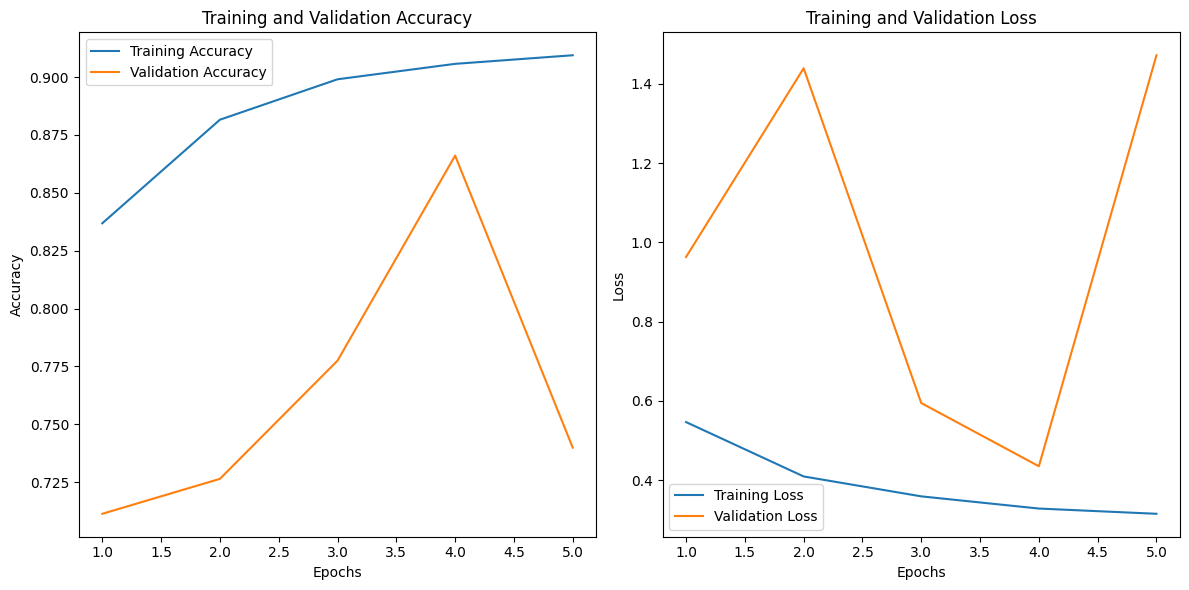

In [22]:
# Plot training history
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion
In this project, I have successfully built and trained a Convolutional Neural Network (CNN) to detect cancer in histopathological images. The model achieved a validation accuracy of 86.61% and an AUC of 95.48%. The training process was optimized using Bayesian hyperparameter tuning, which helped in finding the best model configuration.

The model's performance can be further improved by increasing the dataset size, using more advanced architectures like ResNet or Inception, and applying more sophisticated data augmentation techniques. Additionally, techniques like transfer learning and fine-tuning pre-trained models could also be explored to enhance the model's accuracy.

Overall, this project demonstrates the potential of deep learning in medical image analysis and its application in cancer detection, which can significantly aid in early diagnosis and treatment planning.

In [23]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Set the path to the test directory
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

# Load test images
test_images = []
test_ids = []

for filename in os.listdir(test_dir):
    if filename.endswith(".tif"):
        img_path = os.path.join(test_dir, filename)
        img = load_img(img_path, target_size=(96, 96))  # Adjust target_size based on your model input size
        img_array = img_to_array(img)
        test_images.append(img_array)
        test_ids.append(filename.split('.')[0])

# Convert to numpy array
test_images = np.array(test_images)

# Normalize images if your model requires it (optional)
test_images = test_images / 255.0

# Load your trained model
model = best_model

# Generate predictions
y_pred = model.predict(test_images)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)  # Convert to binary labels if necessary

# Create a DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': y_pred
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")